In [4]:
import pandas as pd
from pandas import HDFStore

import numpy as np
from numpy import array
import h5py

In [5]:
import pickle
import os.path


# file is larger than 2GB, use pickle to read in by chunks
file_path = "common_genes.pkl"
max_bytes = 2**31 - 1

## read
bytes_in = bytearray(0)
input_size = os.path.getsize(file_path)
with open(file_path, 'rb') as f_in:
    for _ in range(0, input_size, max_bytes):
        bytes_in += f_in.read(max_bytes)
        
data2 = pickle.loads(bytes_in)

FileNotFoundError: [Errno 2] No such file or directory: 'common_genes.pkl'

In [3]:
experiment_tag = "003"

In [4]:
input_array = np.stack(data2["seq"], axis=0)
input_array.shape

(42438, 2000, 4)

In [5]:
input_array[0,:,:]

array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

In [6]:
output_array = np.array(data2["E003"])
output_array.shape

(42438,)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten

import tensorflow as tf
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [8]:
from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

In [36]:
from sklearn.utils import shuffle
X_shuffled, Y_shuffled = shuffle(input_array, output_array)

MemoryError: 

In [35]:
X_shuffled

array([[[0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        ...,
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1]],

       [[0, 0, 0, 1],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        ...,
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [1, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        ...,
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 1, 0]],

       ...,

       [[0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        ...,
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        ...,
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0]],

       [[0, 0, 0, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        ...,
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 0]]])

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14199291745069300217
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2432106496
locality {
  bus_id: 1
}
incarnation: 735023747000762064
physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:02:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 2720989184
locality {
  bus_id: 1
}
incarnation: 8338422356232422747
physical_device_desc: "device: 1, name: GeForce GTX 1060 3GB, pci bus id: 0000:05:00.0, compute capability: 6.1"
]


In [12]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, input_shape=(2000, 4), activation="relu", name="Conv1"))
model.add(Conv1D(filters=64, kernel_size=10, activation="relu", name="Conv2"))
model.add(MaxPooling1D(pool_size=5))
# model.add(Dropout(0.5))

model.add(Conv1D(filters=128, kernel_size=10, activation="relu", name="Conv3"))
model.add(Conv1D(filters=128, kernel_size=10, activation="relu", name="Conv4"))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.5))

model.add(Conv1D(filters=256, kernel_size=10, activation="relu", name="Conv5"))
model.add(Conv1D(filters=256, kernel_size=10, activation="relu", name="Conv6"))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.5))

model.add(Conv1D(filters=256, kernel_size=10, activation="relu", name="Conv7"))
model.add(Conv1D(filters=256, kernel_size=10, activation="relu", name="Conv8"))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.5))



model.add(Flatten(name="Flatten1"))

model.add(Dense(625, activation='relu', name='Dense1'))
model.add(Dense(625, activation='relu', name='Dense2'))
model.add(Dense(125, activation='relu', name='Dense3'))
model.add(Dense(1, activation="linear", name='Dense4'))





In [13]:
from keras import Model
from keras.utils import multi_gpu_model


class ModelMGPU(Model):
    def __init__(self, ser_model, gpus):
        pmodel = multi_gpu_model(ser_model, gpus)
        self.__dict__.update(pmodel.__dict__)
        self._smodel = ser_model
    
    def __getattribute__(self, attrname):
        # return Model.__getattribute__(self, attrname)
        if 'load' in attrname or 'save' in attrname:
            return getattr(self._smodel, attrname)
        
        return super(ModelMGPU, self).__getattribute__(attrname)




parallel_model = ModelMGPU(model, gpus = 2)
parallel_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mae'])

print(model.summary())
print(parallel_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv1D)               (None, 1991, 64)          2624      
_________________________________________________________________
Conv2 (Conv1D)               (None, 1982, 64)          41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 396, 64)           0         
_________________________________________________________________
Conv3 (Conv1D)               (None, 387, 128)          82048     
_________________________________________________________________
Conv4 (Conv1D)               (None, 378, 128)          163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 126, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 126, 128)          0         
__________

In [14]:
from keras.callbacks import ModelCheckpoint

# saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath=("models/experiments_" + experiment_tag +".hdf5"), verbose=1, save_best_only=True)

In [15]:
history = []

In [16]:

history.append(
    parallel_model.fit(X_shuffled[:-2000], Y_shuffled[:-2000], initial_epoch=0 ,epochs=30, batch_size=512, shuffle=True ,validation_split=0.2, callbacks=[checkpointer]))

Train on 32350 samples, validate on 8088 samples
Epoch 1/30
32350/32350 [==============================] - 46s 1ms/step - loss: 1.5392 - mean_absolute_error: 9.2678 - val_loss: 1.1222 - val_mean_absolute_error: 8.2168

Epoch 00001: val_loss improved from inf to 1.12217, saving model to models/experiments_003.hdf5
Epoch 2/30
32350/32350 [==============================] - 37s 1ms/step - loss: 1.1249 - mean_absolute_error: 8.8351 - val_loss: 1.1393 - val_mean_absolute_error: 8.1815

Epoch 00002: val_loss did not improve
Epoch 3/30
32350/32350 [==============================] - 38s 1ms/step - loss: 1.0615 - mean_absolute_error: 8.7420 - val_loss: 1.3662 - val_mean_absolute_error: 8.2196

Epoch 00003: val_loss did not improve
Epoch 4/30
32350/32350 [==============================] - 38s 1ms/step - loss: 1.0511 - mean_absolute_error: 8.7146 - val_loss: 0.9924 - val_mean_absolute_error: 8.0051

Epoch 00004: val_loss improved from 1.12217 to 0.99245, saving model to models/experiments_003.hdf5

In [18]:
import matplotlib.pyplot as plt

def plot_histories(histories):
    plt.clf()
    train_mae = []
    val_mae = []
    
    loss = []
    val_loss= []
    for history in histories:
        for error in history.history['mean_absolute_error']:
            train_mae.append(error)
        for error in history.history['val_mean_absolute_error']:
            val_mae.append(error)
        for error in history.history['loss']:
            loss.append(error)
        for error in history.history['val_loss']:
            val_loss.append(error)
    epochs = range(1, len(train_mae) + 1)

    plt.plot(epochs, train_mae, 'b', label='Training mae')
    plt.plot(epochs, val_mae, 'r', label='val mae')
    plt.title('mean absolute error')
    plt.legend()
    plt.show()
    
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='val loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


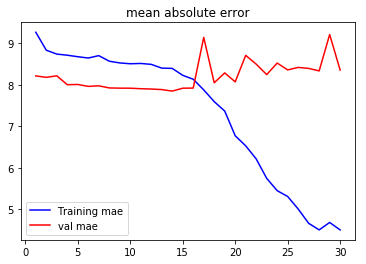

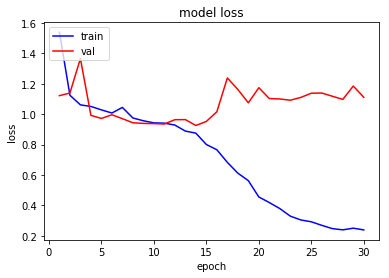

In [19]:

# plot traning history  
plot_histories(history)

## Model prediction

In [37]:
from keras.models import load_model

best_model = load_model("models/experiments_" + experiment_tag + ".hdf5")

pred = best_model.predict(X_shuffled[-2000:])
exp = Y_shuffled[-2000:]

pred_log = np.log(pred+1)
exp_log = np.log(exp+1)

/home/qihzhong/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


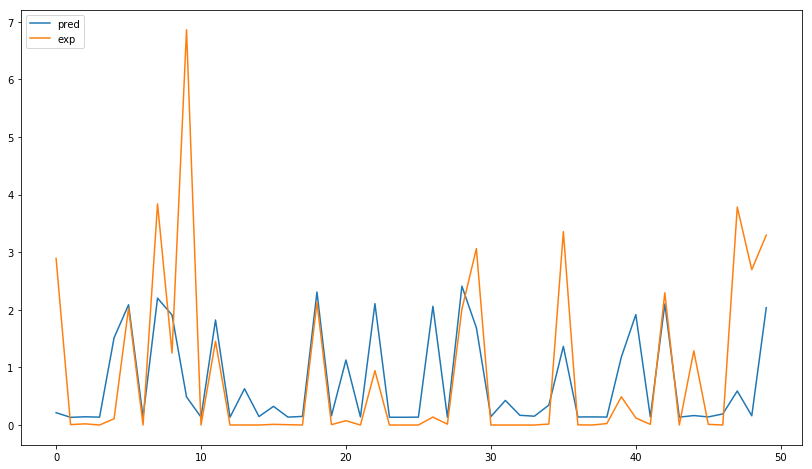

In [38]:
plt.figure(figsize=(14, 8))
plt.plot(pred_log[:50], label='pred')
plt.plot(exp_log[:50], label='actual exp')
plt.legend(['pred', 'exp'], loc='upper left')
plt.show()

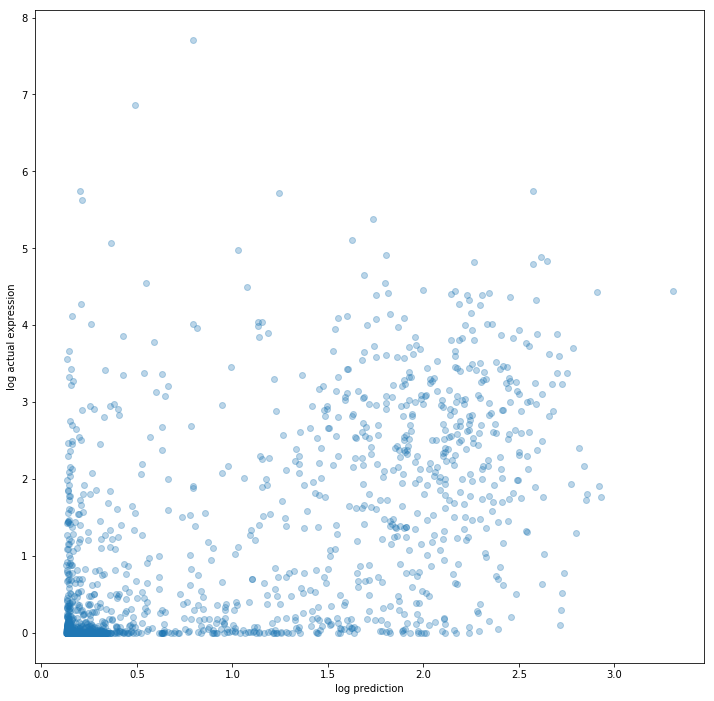

In [39]:
plt.figure(figsize=(12, 12))
plt.xlabel("log prediction")
plt.ylabel("log actual expression")
plt.scatteir````````(pred_log, exp_log, alpha=0.3)
plt.show()


**Pearson Correlation**

In [40]:
np.corrcoef(pred_log, exp_log.reshape((2000,1)), rowvar=False)[0,1]


from scipy import stats
pearson_coef, p_value = stats.pearsonr(pred_log, exp_log.reshape((2000,1)))
print("pearson coef = " , pearson_coef)
print("p value = ", p_value)

pearson coef =  [0.66474451]
p value =  [2.54348834e-255]


**Random results based on means and standard deviation**

pearson coef =  -0.033476286267277326
p value =  0.13450035862024734


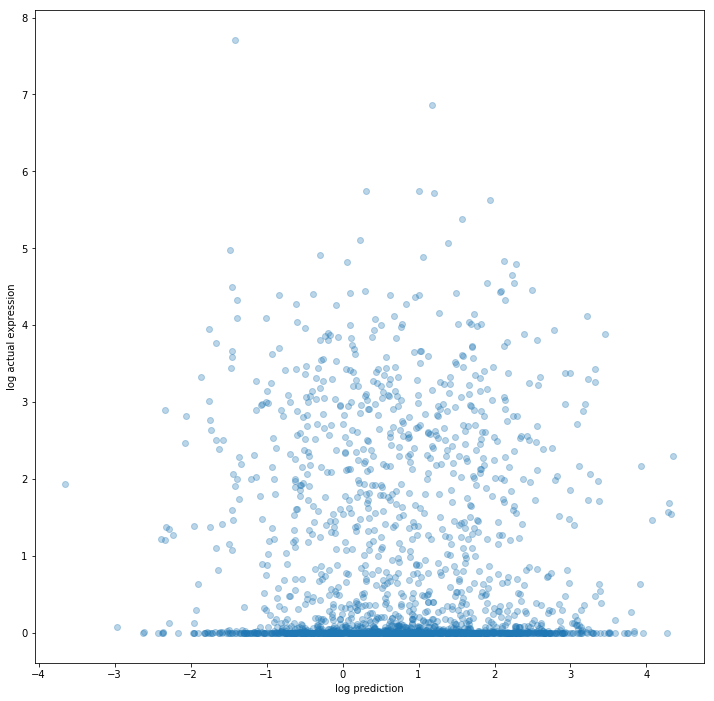

In [41]:
random_results = np.random.normal(exp_log.mean(), exp_log.std(), 2000)

pearson_coef, p_value = stats.pearsonr(random_results, exp_log)
print("pearson coef = " , pearson_coef)
print("p value = ", p_value)

plt.figure(figsize=(12, 12))
plt.xlabel("log prediction")
plt.ylabel("log actual expression")
plt.scatter(random_results, exp_log, alpha=0.3)
plt.show()

In [42]:
np.corrcoef(random_results, exp_log.reshape((2000,1)), rowvar=False)[0,1]

-0.03347628626727731

**Random shuffle of expressions**

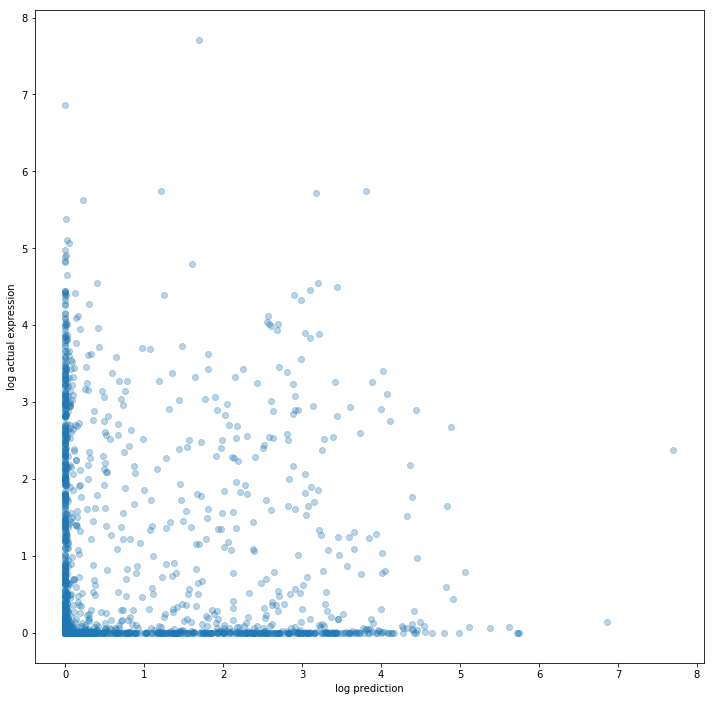

In [43]:
exp_shuffled = shuffle(exp_log)

plt.figure(figsize=(12, 12))
plt.xlabel("log prediction")
plt.ylabel("log actual expression")
plt.scatter(exp_shuffled, exp_log, alpha=0.3)
plt.show()

In [44]:
pearson_coef, p_value = stats.pearsonr(exp_shuffled.reshape(2000,1), exp_log.reshape((2000,1)))
print("pearson coef = " , pearson_coef)
print("p value = ", p_value)

pearson coef =  [-0.02293024]
p value =  [0.30537972]


In [45]:
histories = []
for h in history:
    histories.append(h.history)

with open("models/history_" + experiment_tag + ".pkl", 'wb') as f_out:
    pickle.dump(histories ,f_out)

    
# read from pickled history
h = pickle.load(open("models/history_" + experiment_tag + ".pkl", "rb"))